In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'AKE.PA'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,1411,-1196,215,23,377,824,896,2248,661,...,5476,687,0,93,1056,1205,3164,175,-175,63.0
1,2014-03-31,1523,-1257,266,66,561,951,912,2619,0,...,5852,735,0,367,1415,1201,3474,60,-140,67.0
2,2014-06-30,1520,-1245,275,51,169,936,921,2197,663,...,5481,673,0,73,1050,1200,3144,114,-115,67.0
3,2014-09-30,1478,-1214,264,25,360,910,975,2402,0,...,5802,648,0,212,1187,1202,3309,171,-119,67.0
4,2014-12-31,1431,-1213,218,25,1149,839,977,3131,747,...,6814,704,0,107,1131,1194,3285,162,-112,67.0


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,74.0,2507,-2129,378,9,1592,1360,1399,...,2178,13511,1149,442,256,2410,2414,6211,457,-242
37,2023-03-31,2023-04-21,75.0,2524,-2022,502,133,1917,1546,1470,...,2125,13919,1183,0,656,2416,2950,6597,143,-196
38,2023-06-30,2023-07-21,75.0,2442,-1900,542,152,1666,1460,1379,...,2109,13516,998,412,248,2222,2809,6384,274,-152
39,2023-09-30,2023-10-21,75.0,2326,-1835,491,117,1900,1396,1347,...,2099,13667,946,0,664,2204,2955,6317,393,-149
40,2023-12-31,2024-02-11,75.0,2222,-1797,425,23,2045,1261,1208,...,2416,14517,1036,389,152,2079,3578,7314,462,-181


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,74.0,2507,-2129,378,9,1592,1360,1399,...,13511,1149,442,256,2410,2414,6211,457,-242,0.980663
37,2023-03-31,2023-04-21,75.0,2524,-2022,502,133,1917,1546,1470,...,13919,1183,0,656,2416,2950,6597,143,-196,0.932003
38,2023-06-30,2023-07-21,75.0,2442,-1900,542,152,1666,1460,1379,...,13516,998,412,248,2222,2809,6384,274,-152,0.918362
39,2023-09-30,2023-10-21,75.0,2326,-1835,491,117,1900,1396,1347,...,13667,946,0,664,2204,2955,6317,393,-149,0.918837
40,2023-12-31,2024-02-11,75.0,2222,-1797,425,23,2045,1261,1208,...,14517,1036,389,152,2079,3578,7314,462,-181,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,74.0,2507,-2129,378,9,1592,1360,1399,...,13511,1149,442,256,2410,2414,6211,457,-242,0.980663
37,2023-03-31,2023-04-21,75.0,2524,-2022,502,133,1917,1546,1470,...,13919,1183,0,656,2416,2950,6597,143,-196,0.932003
38,2023-06-30,2023-07-21,75.0,2442,-1900,542,152,1666,1460,1379,...,13516,998,412,248,2222,2809,6384,274,-152,0.918362
39,2023-09-30,2023-10-21,75.0,2326,-1835,491,117,1900,1396,1347,...,13667,946,0,664,2204,2955,6317,393,-149,0.918837
40,2023-12-31,2024-02-11,75.0,2222,-1797,425,23,2045,1261,1208,...,14517,1036,389,152,2079,3578,7314,462,-181,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,59.929241,2013-12-31,1411.0,1.460317,36.698413,63.0,1400.0,22.222222,377.0,...,0.422206,0.577794,6.849515,6.96361,14.970822,5.339286,0.152374,0.0163,0.016801,0.039792
1,2014-02-24,57.773716,2013-12-31,1411.0,1.460317,36.698413,63.0,1400.0,22.222222,377.0,...,0.422206,0.577794,6.849515,6.96361,14.970822,5.339286,0.152374,0.0163,0.016801,0.039792
2,2014-03-03,59.775276,2013-12-31,1411.0,1.460317,36.698413,63.0,1400.0,22.222222,377.0,...,0.422206,0.577794,6.849515,6.96361,14.970822,5.339286,0.152374,0.0163,0.016801,0.039792
3,2014-03-10,56.585987,2013-12-31,1411.0,1.460317,36.698413,63.0,1400.0,22.222222,377.0,...,0.422206,0.577794,6.849515,6.96361,14.970822,5.339286,0.152374,0.0163,0.016801,0.039792
4,2014-03-17,58.822155,2013-12-31,1411.0,1.460317,36.698413,63.0,1400.0,22.222222,377.0,...,0.422206,0.577794,6.849515,6.96361,14.970822,5.339286,0.152374,0.0163,0.016801,0.039792


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,59.929241,2013-12-31,1411.0,1.460317,36.698413,63.0,1400.0,22.222222,377.0,...,5.339286,0.152374,0.0163,0.016801,0.039792,41.038502,1.633020,0.668948,1.162747,2.696816
1,2014-02-24,57.773716,2013-12-31,1411.0,1.460317,36.698413,63.0,1400.0,22.222222,377.0,...,5.339286,0.152374,0.0163,0.016801,0.039792,39.562436,1.574284,0.644887,1.138686,2.599817
2,2014-03-03,59.775276,2013-12-31,1411.0,1.460317,36.698413,63.0,1400.0,22.222222,377.0,...,5.339286,0.152374,0.0163,0.016801,0.039792,40.933070,1.628825,0.667229,1.161028,2.689887
3,2014-03-10,56.585987,2013-12-31,1411.0,1.460317,36.698413,63.0,1400.0,22.222222,377.0,...,5.339286,0.152374,0.0163,0.016801,0.039792,38.749100,1.541919,0.631630,1.125428,2.546369
4,2014-03-17,58.822155,2013-12-31,1411.0,1.460317,36.698413,63.0,1400.0,22.222222,377.0,...,5.339286,0.152374,0.0163,0.016801,0.039792,40.280389,1.602853,0.656590,1.150389,2.646997


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

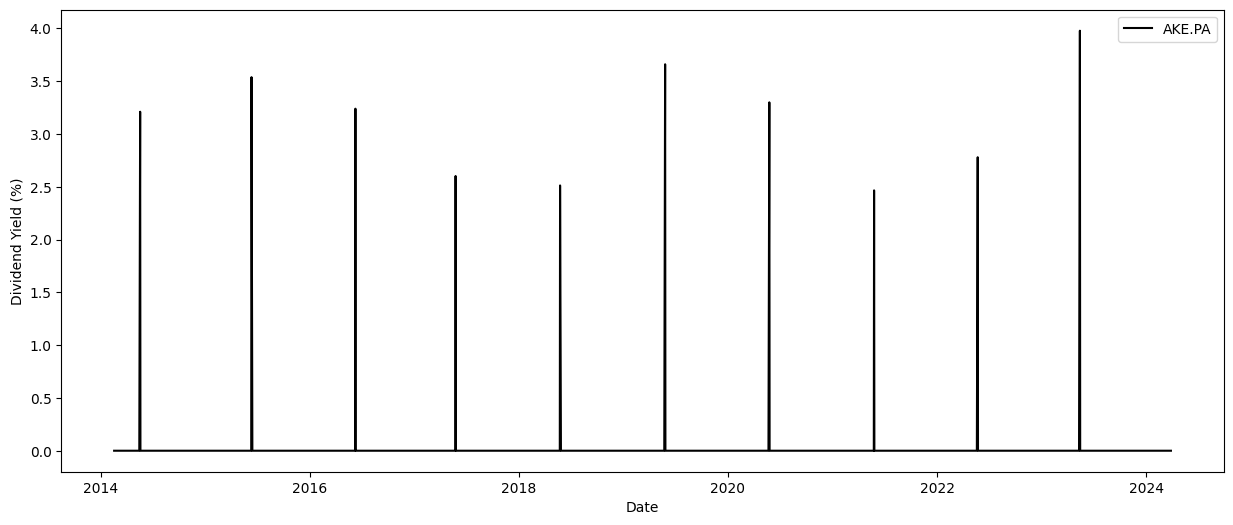

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.189714
share_price      1.000000
Name: share_price, dtype: float64


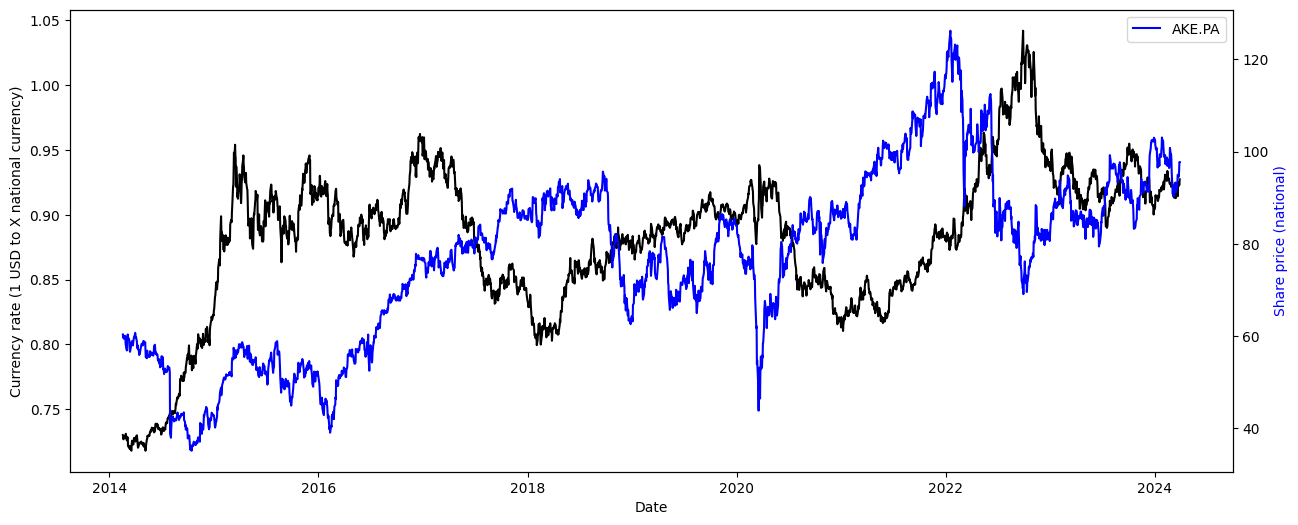

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

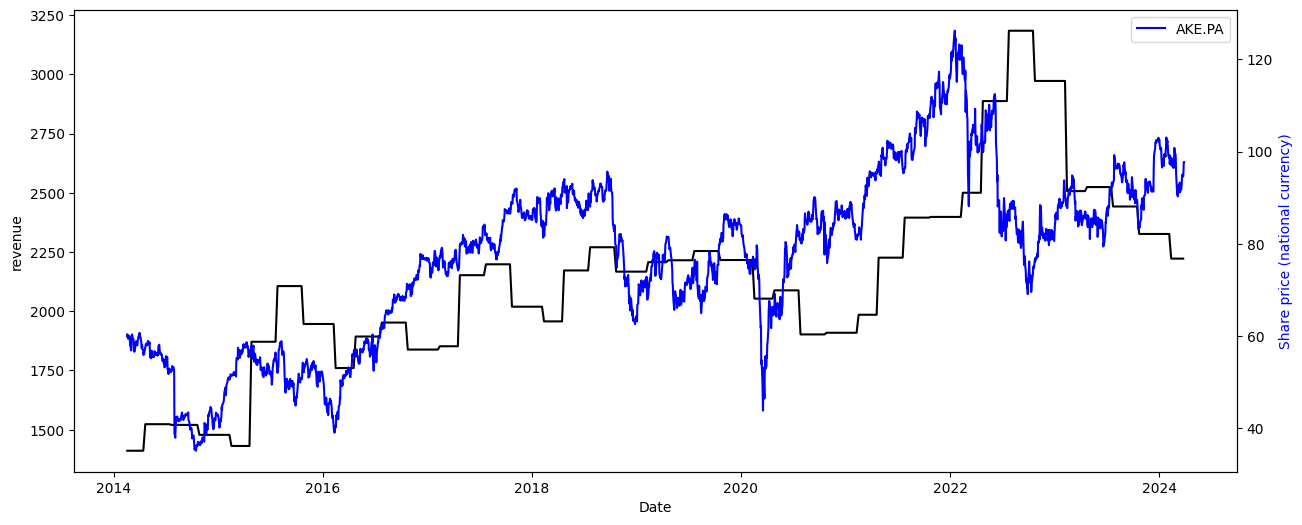

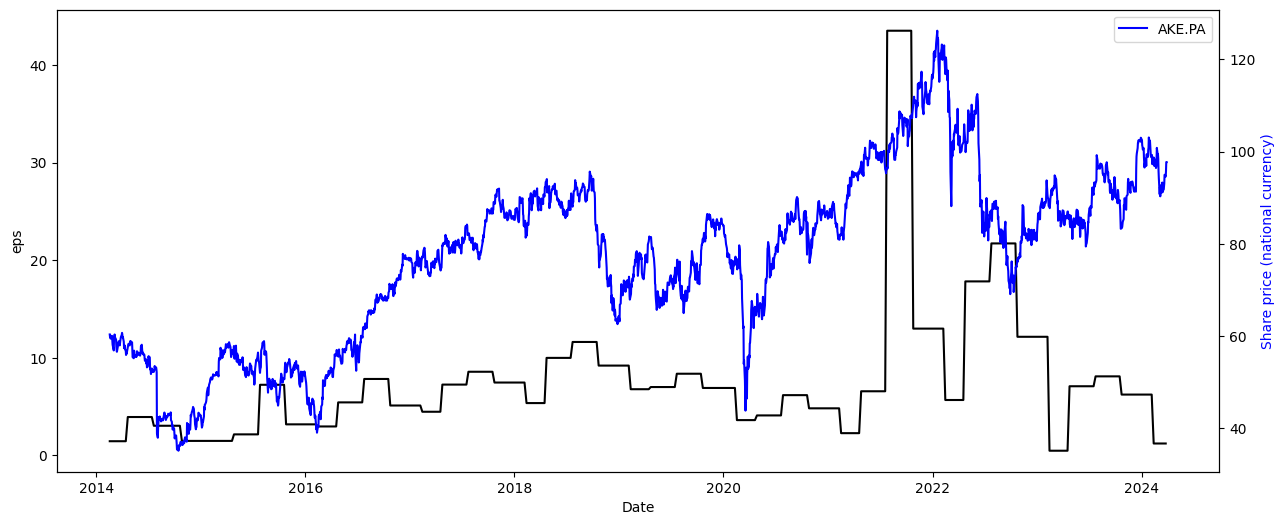

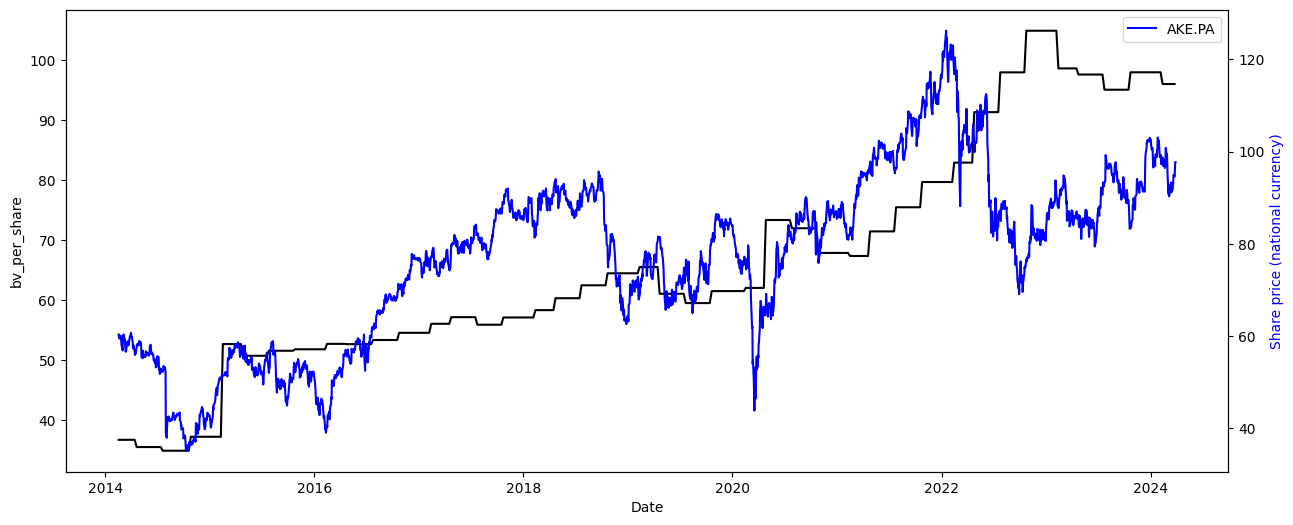

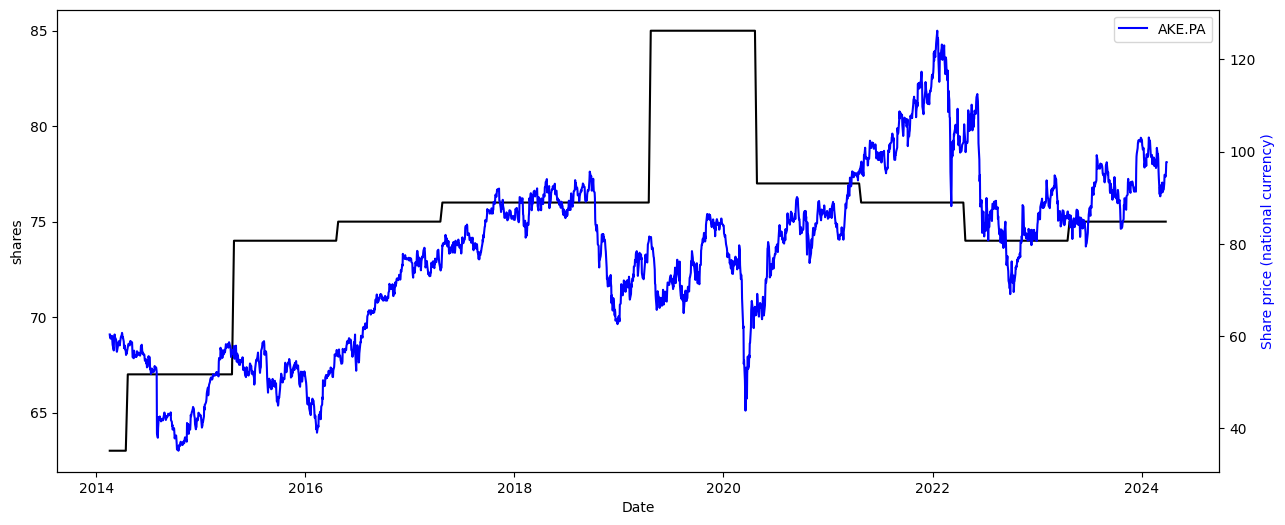

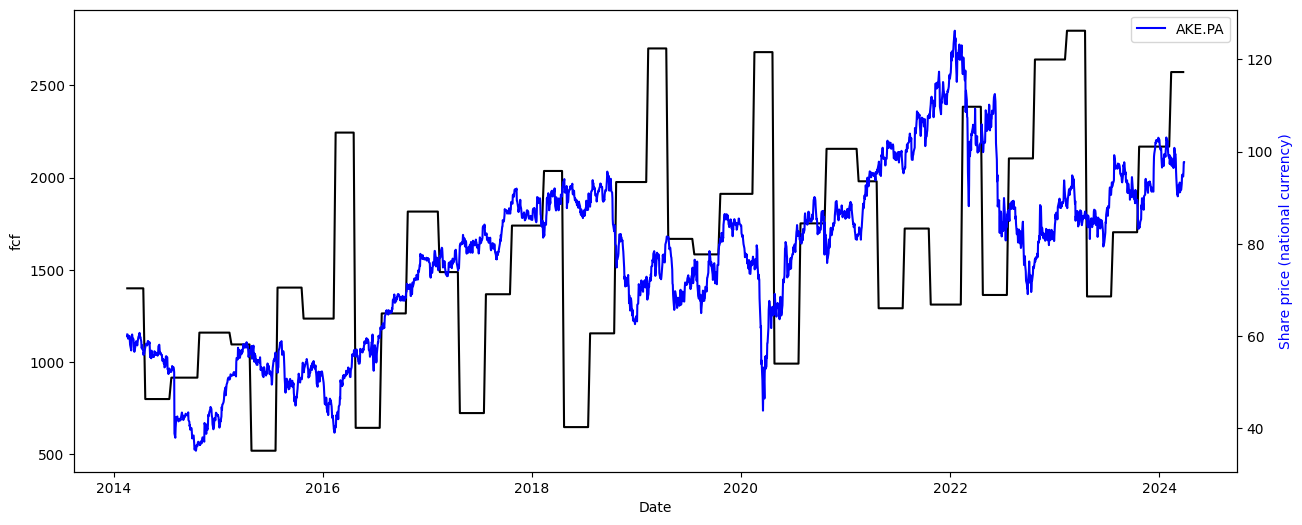

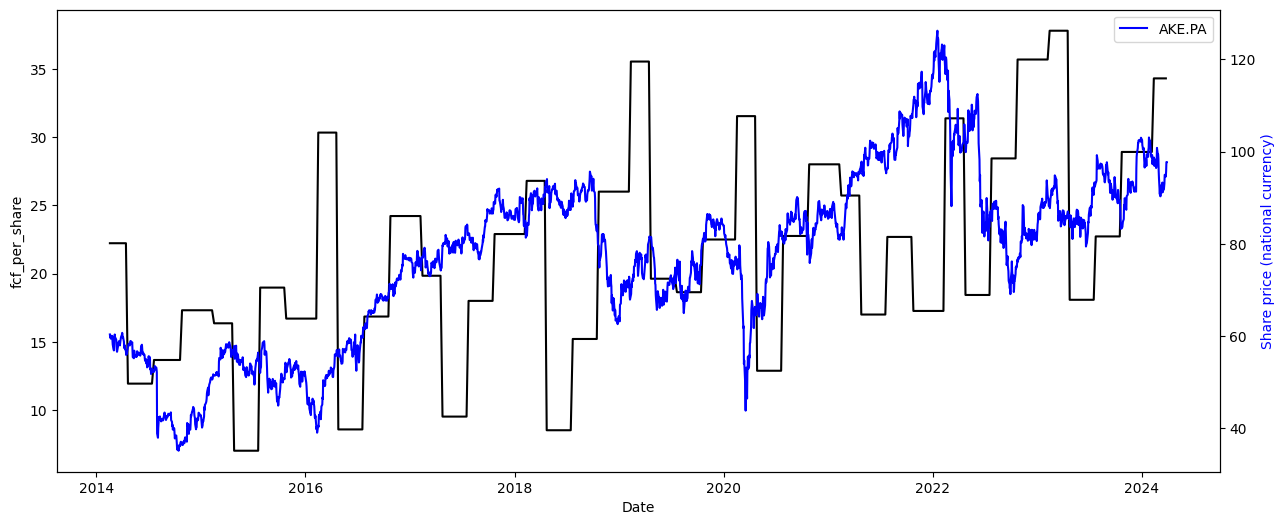

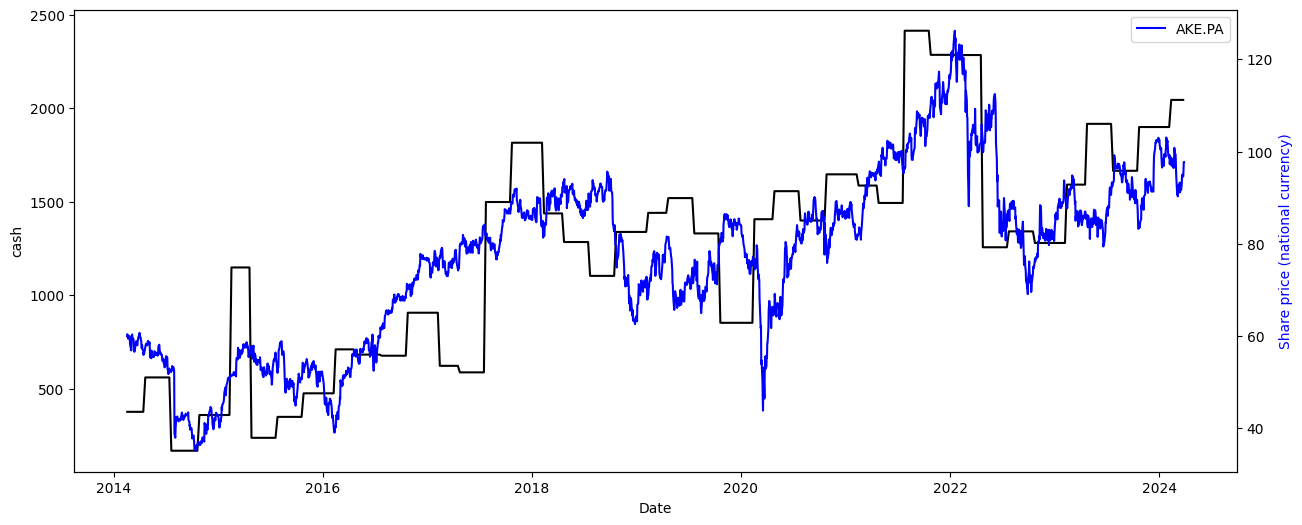

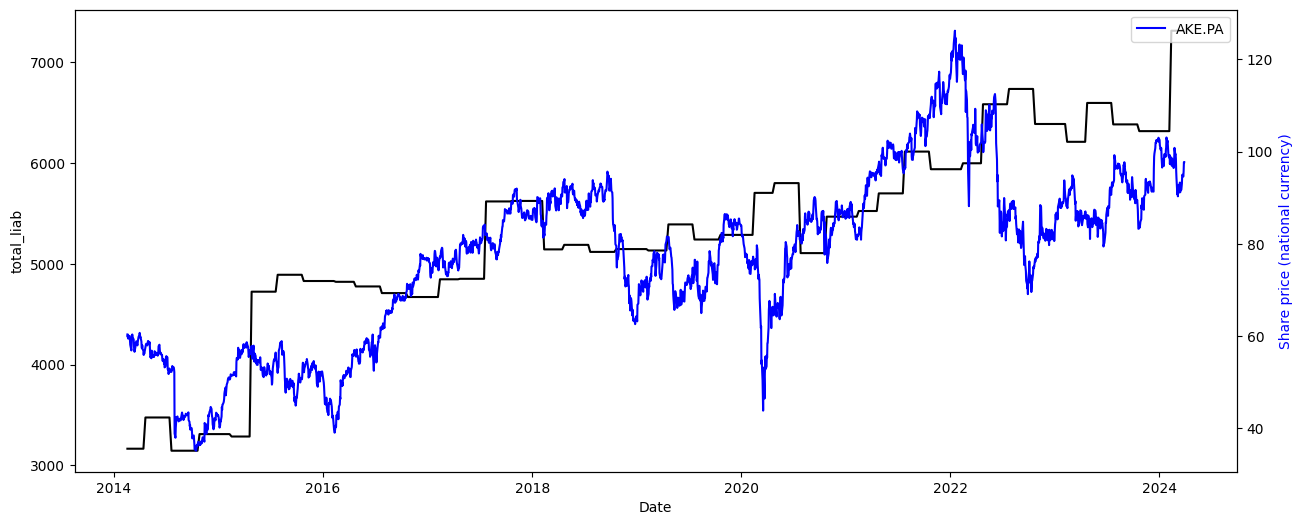

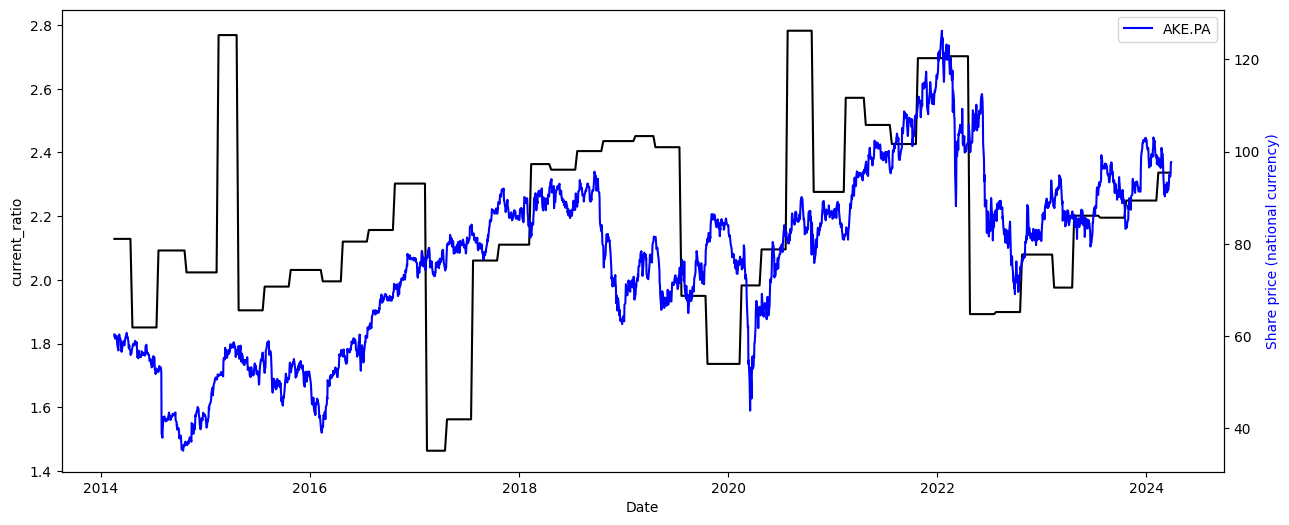

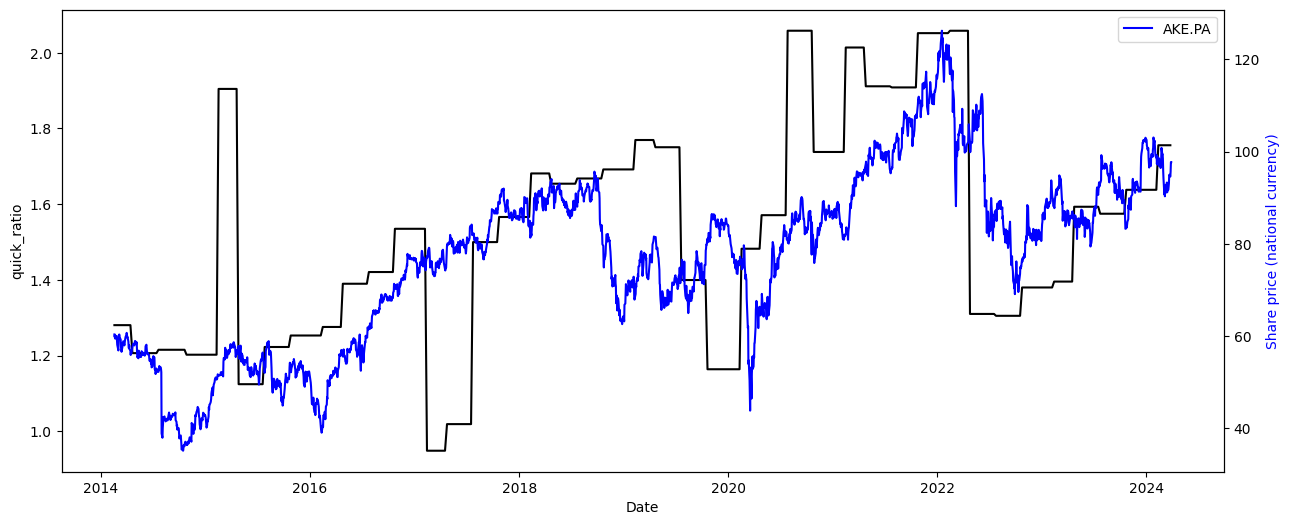

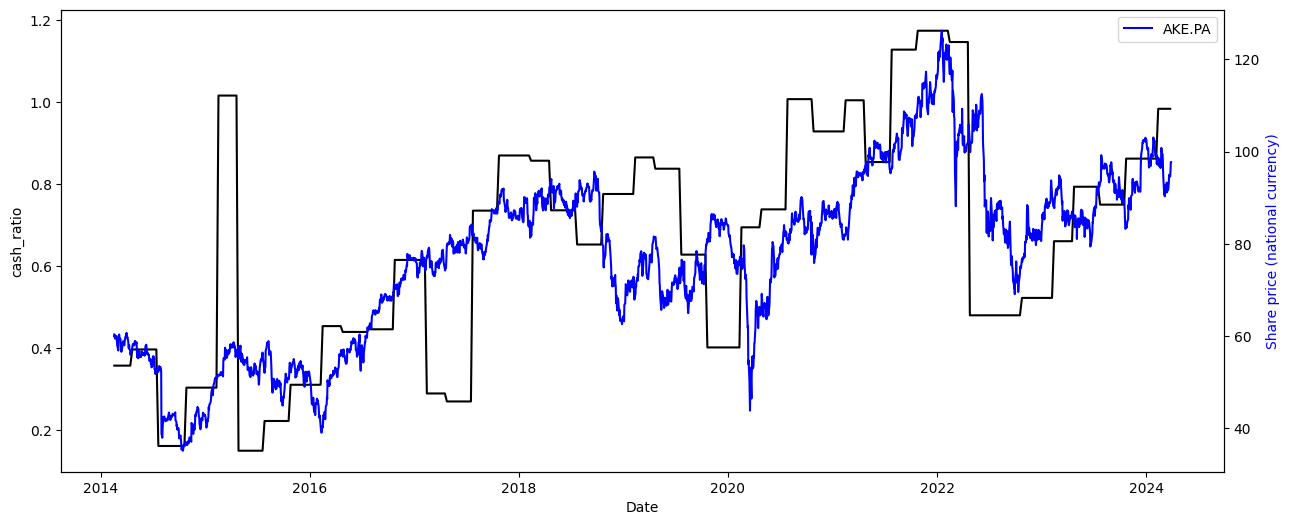

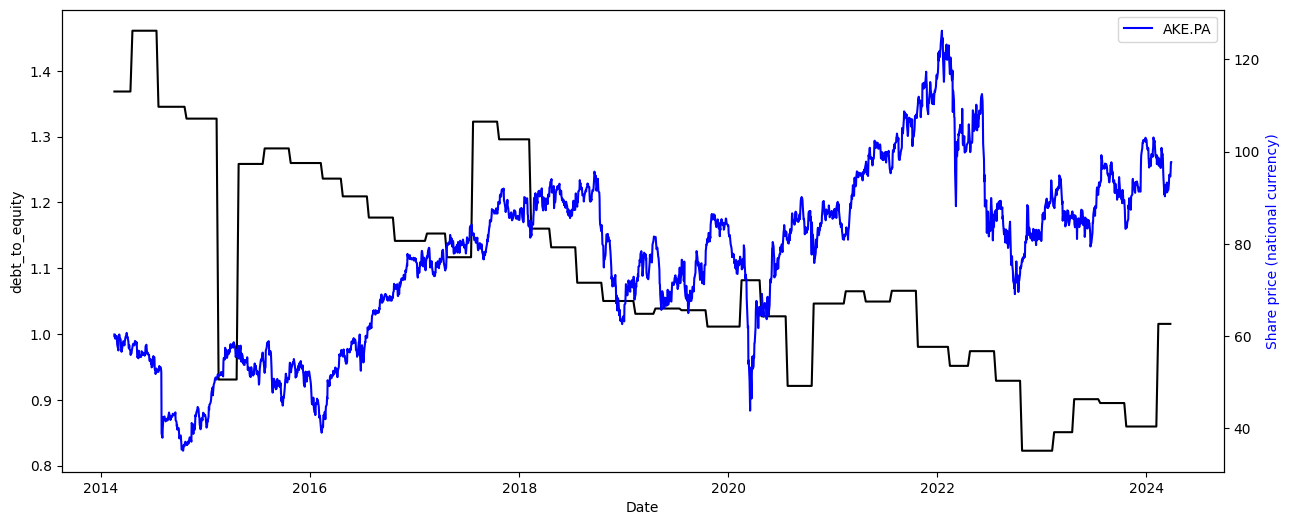

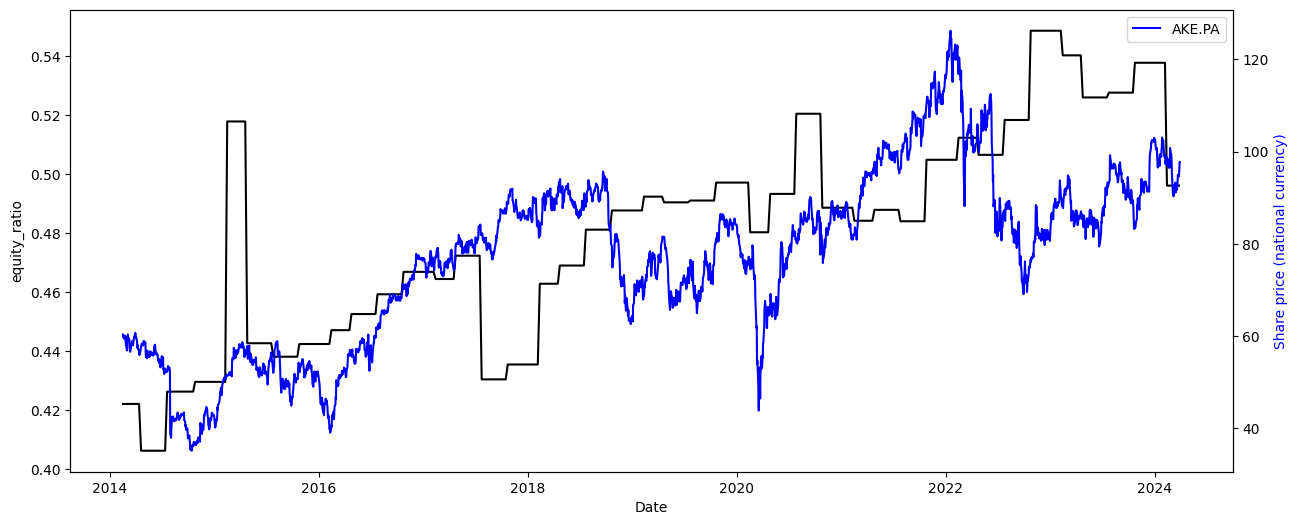

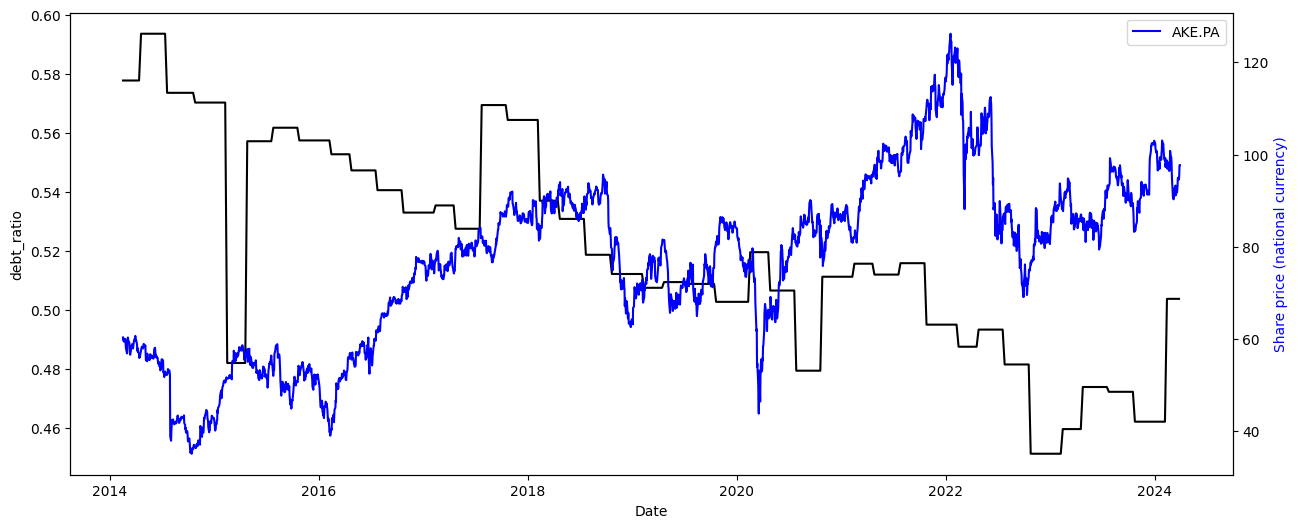

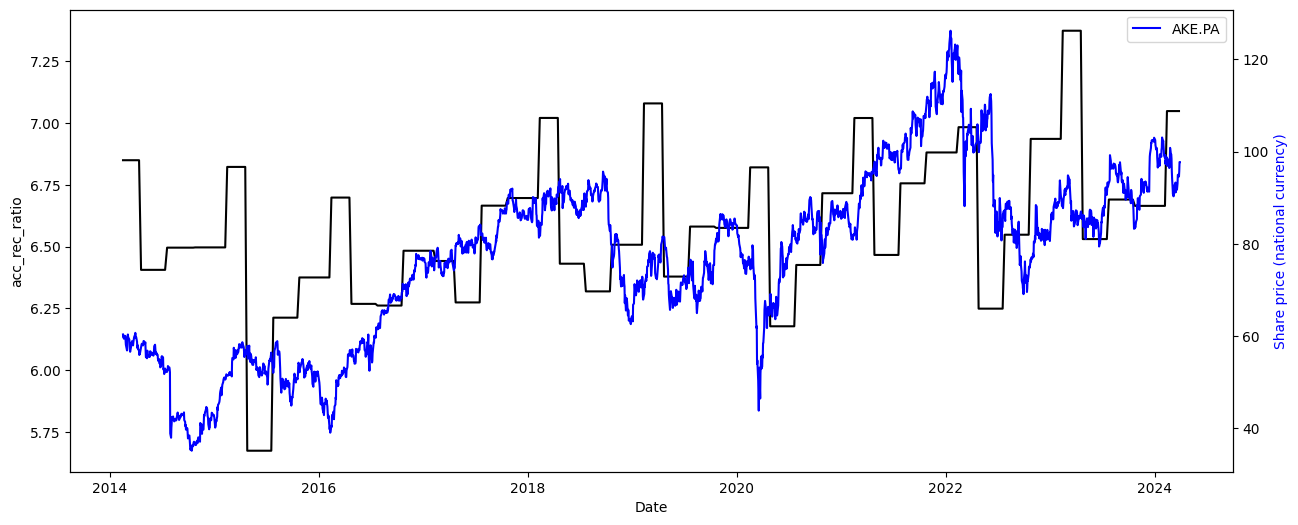

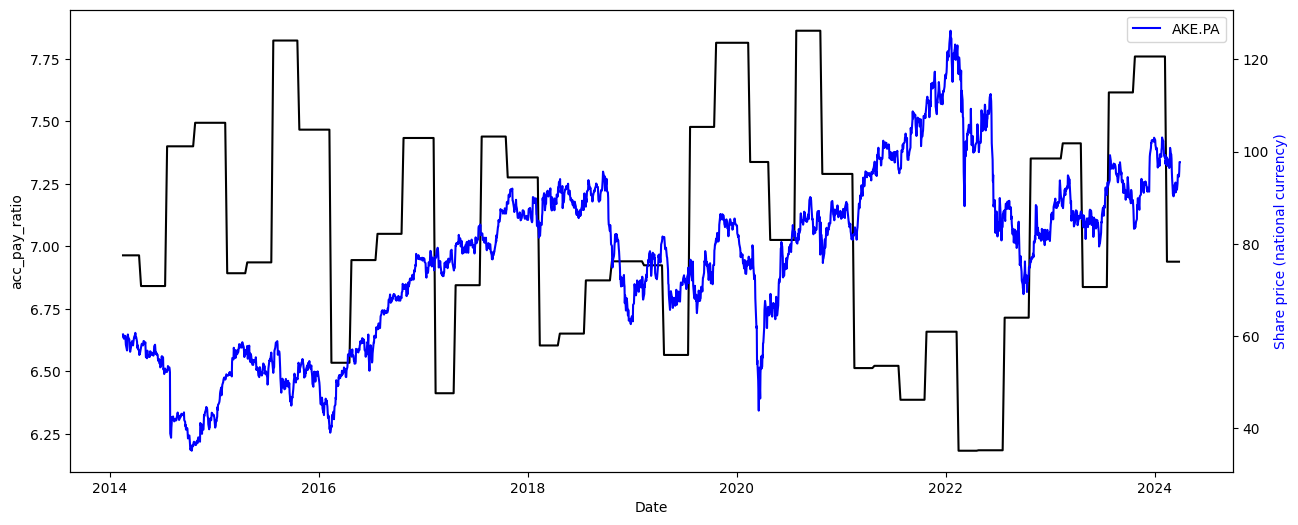

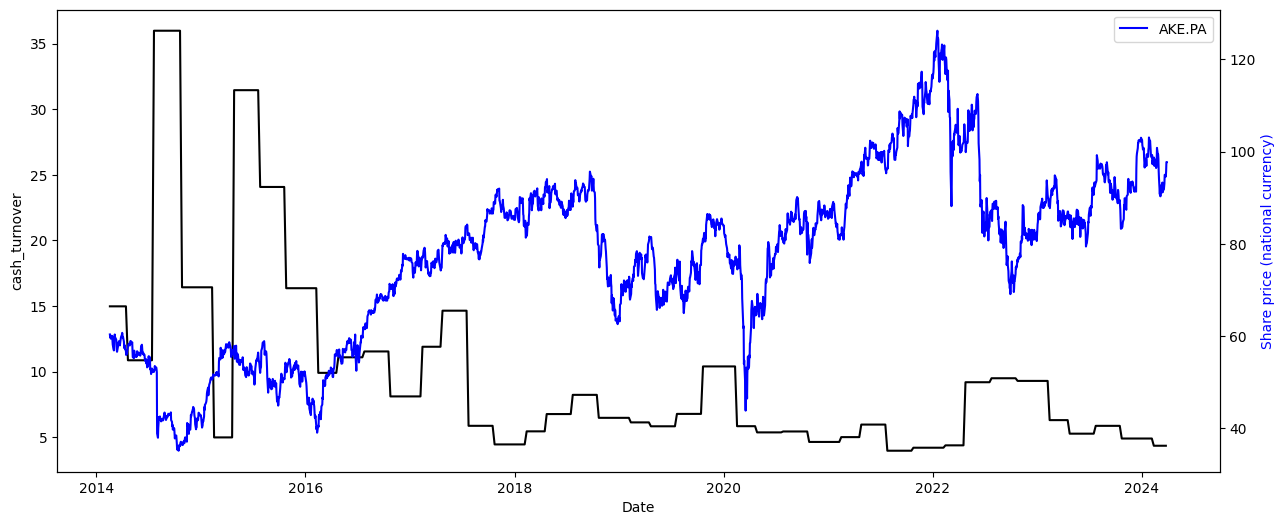

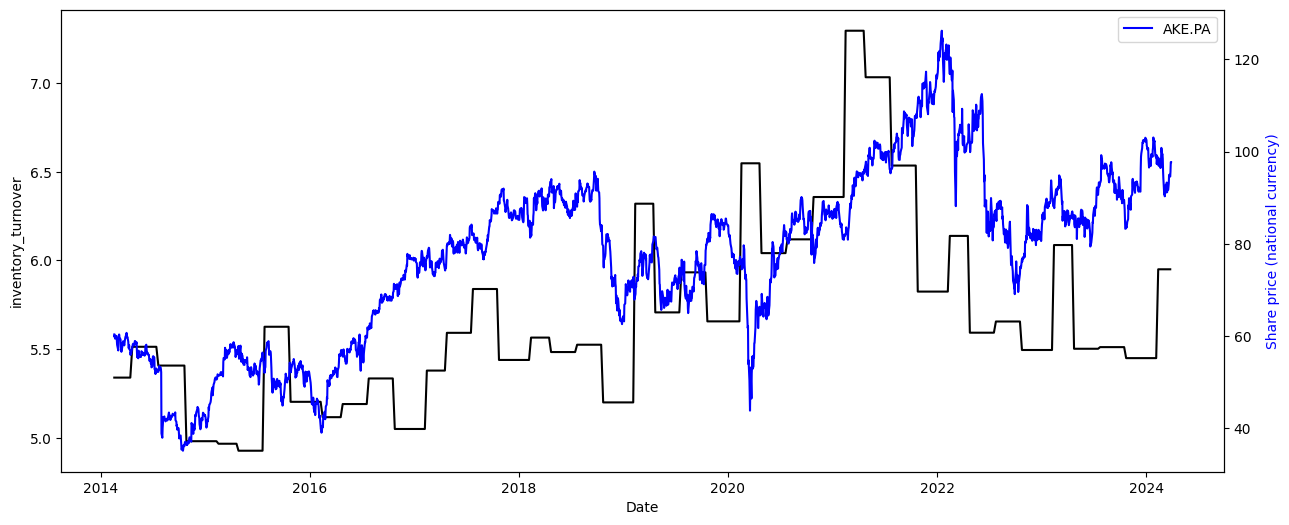

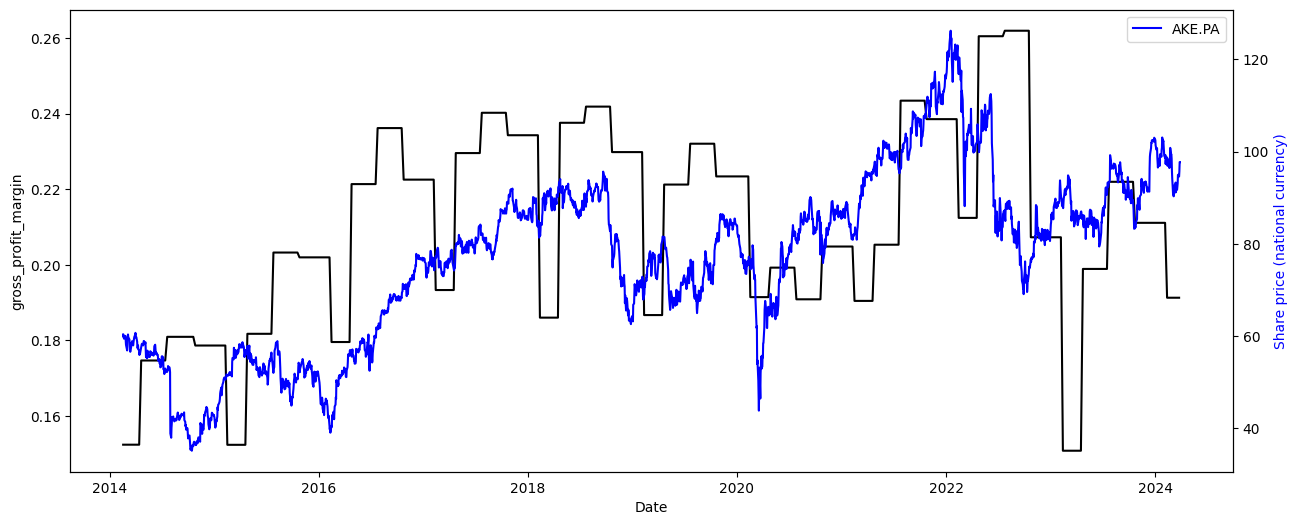

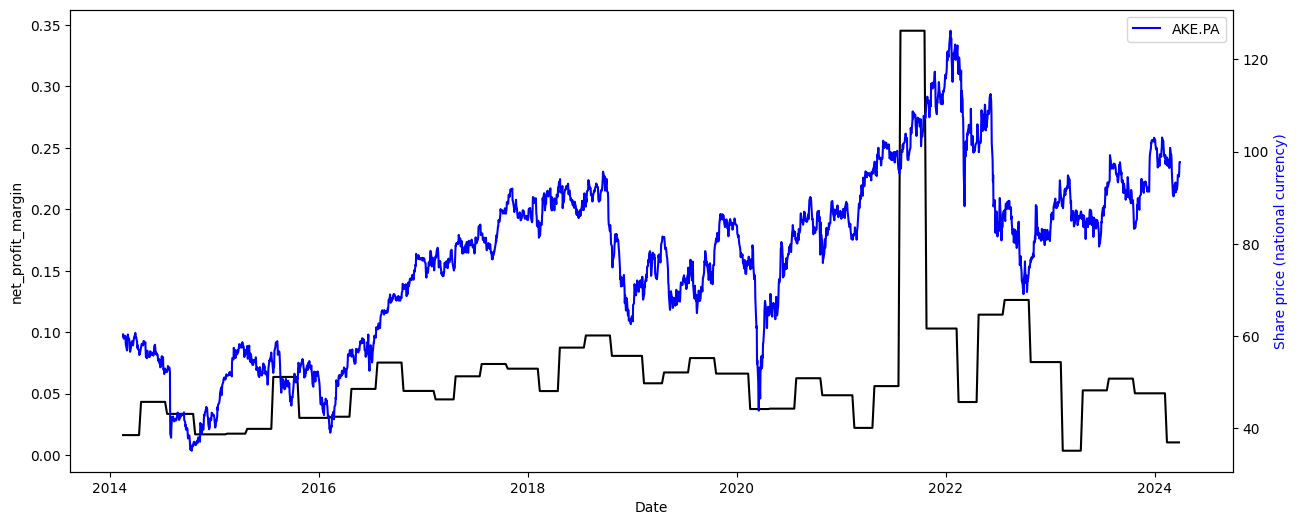

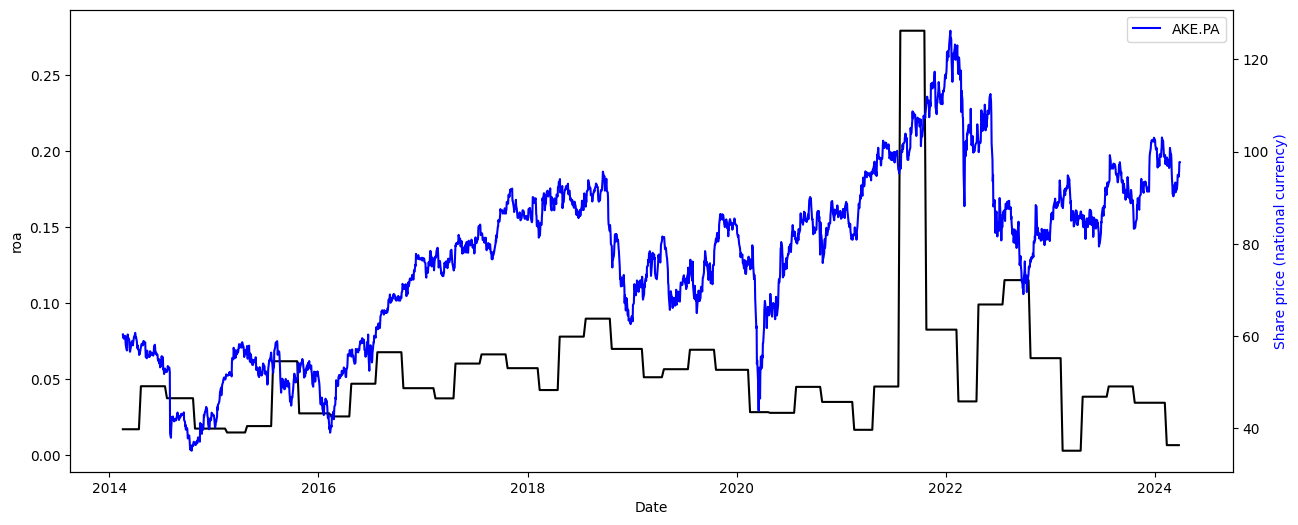

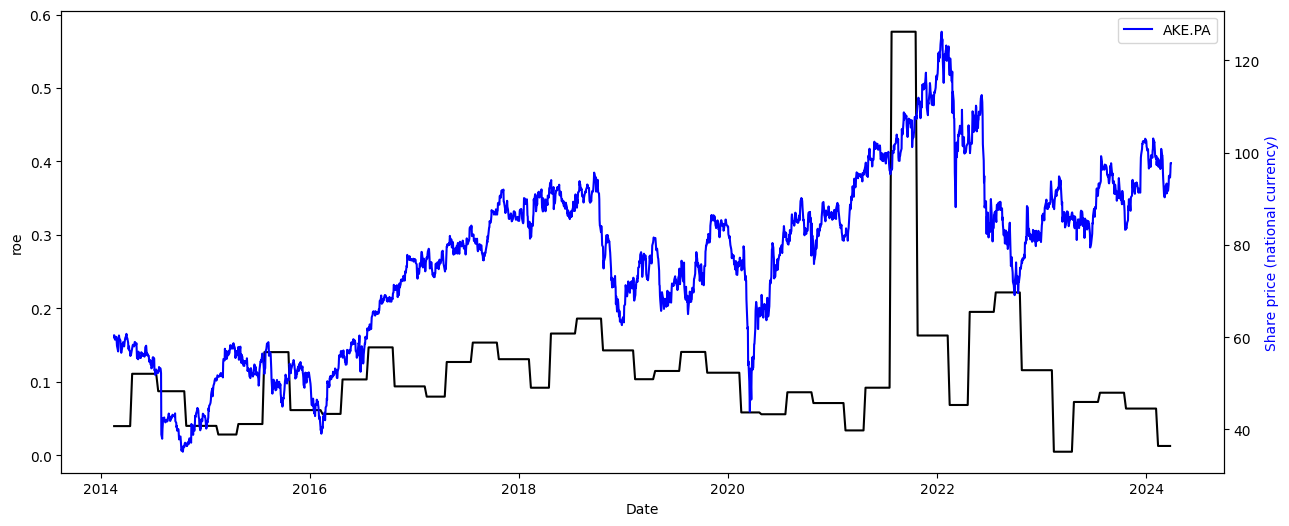

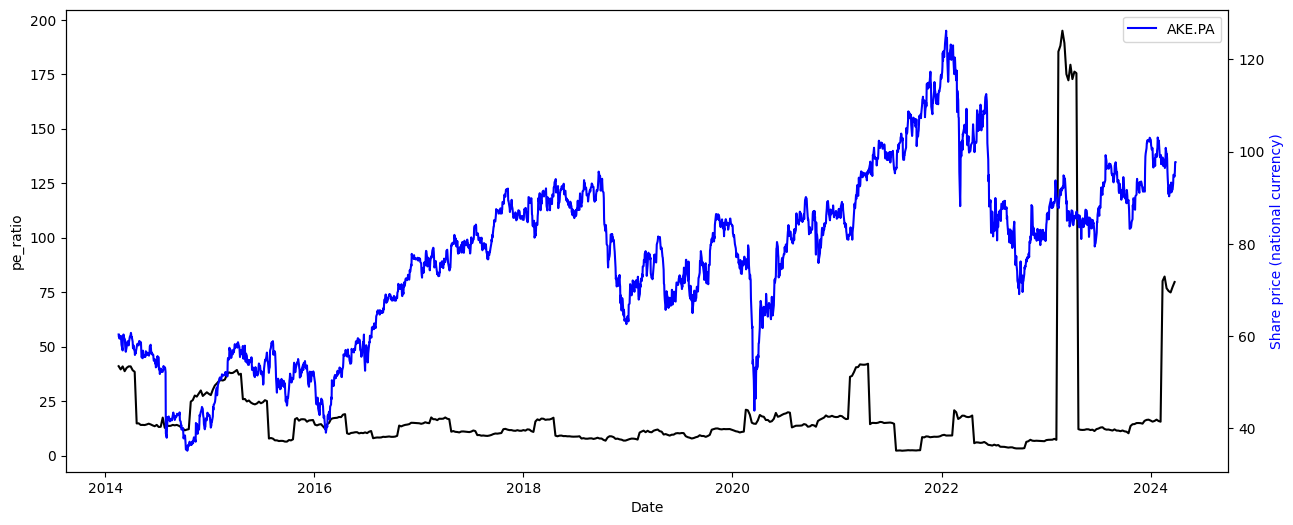

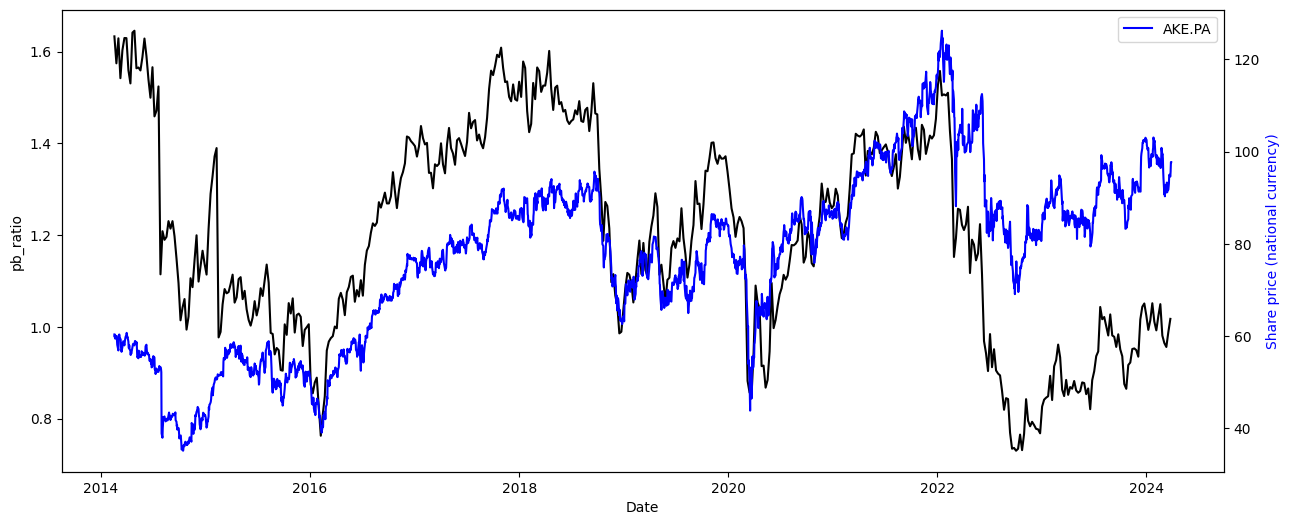

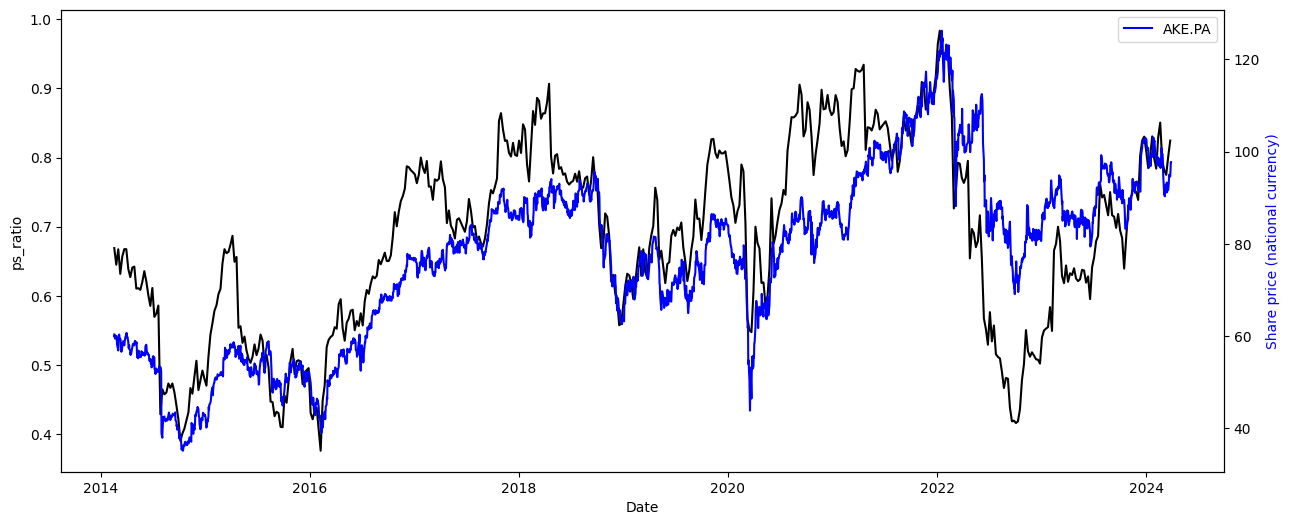

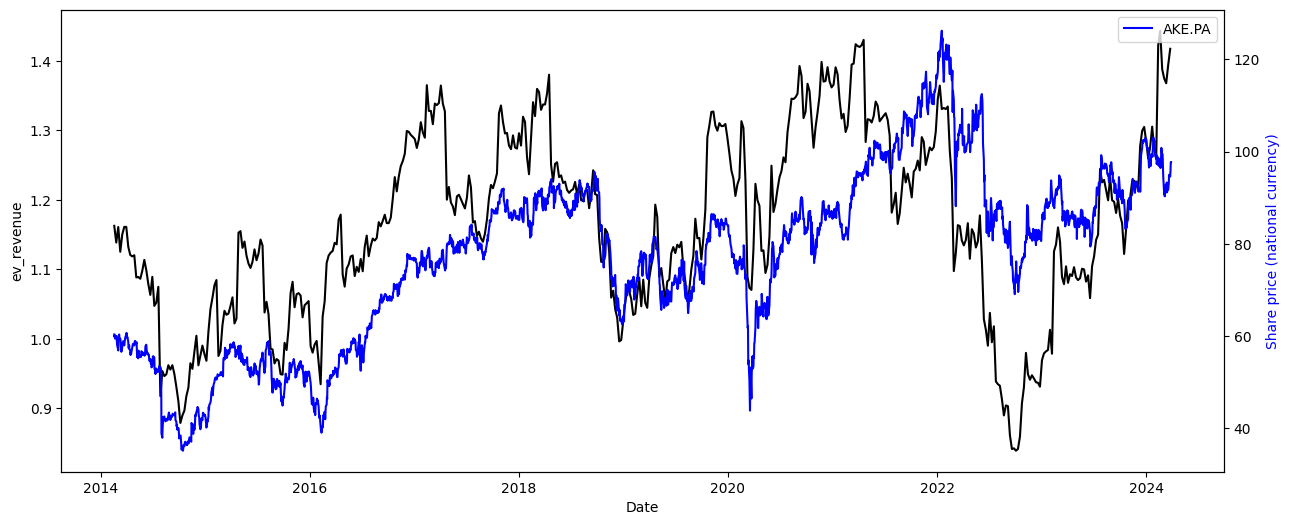

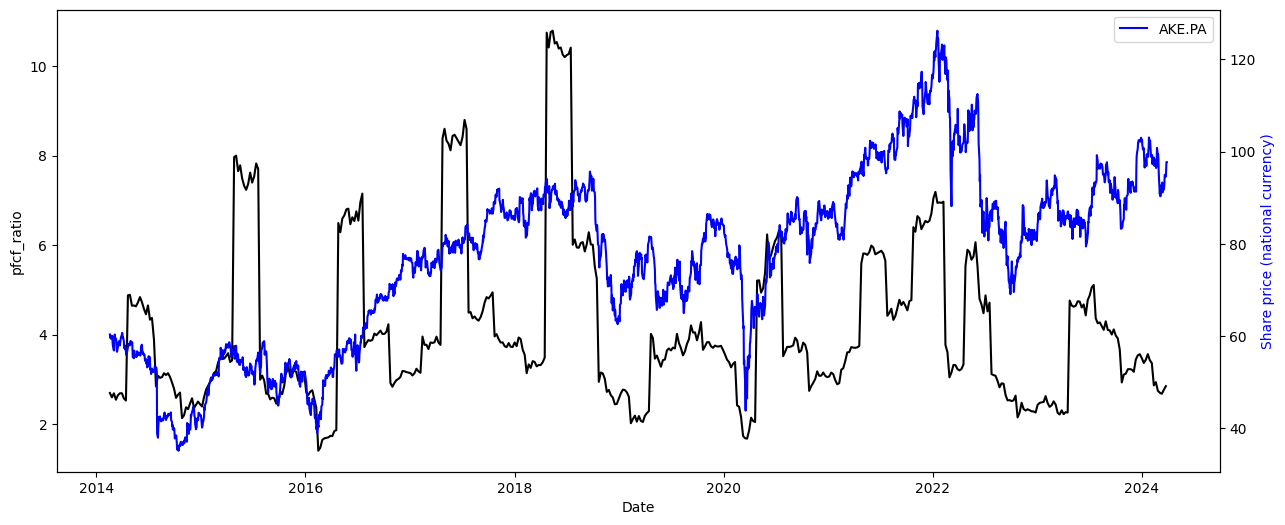

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

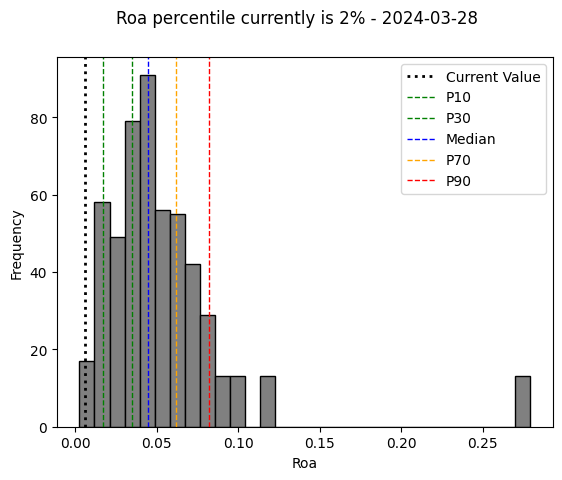

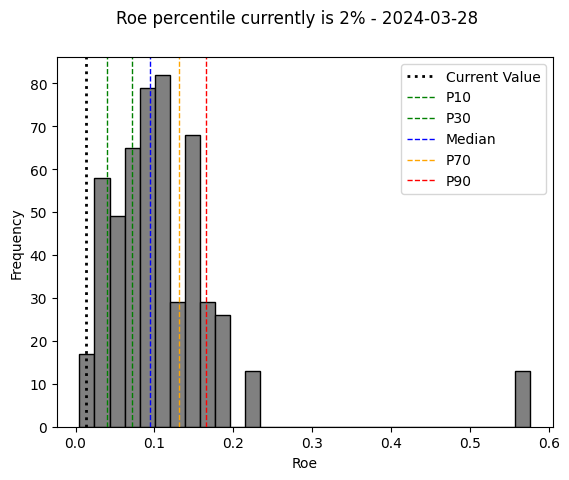

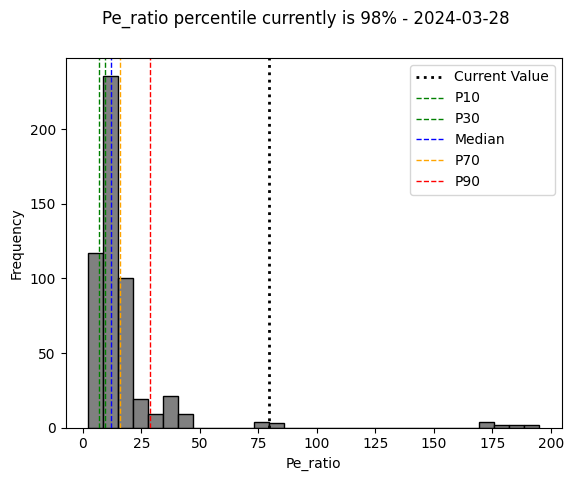

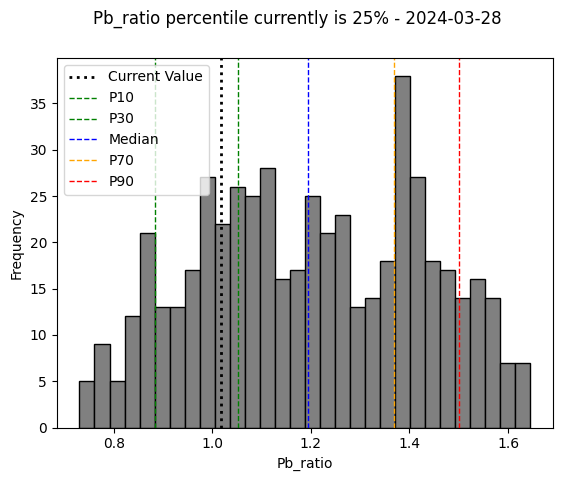

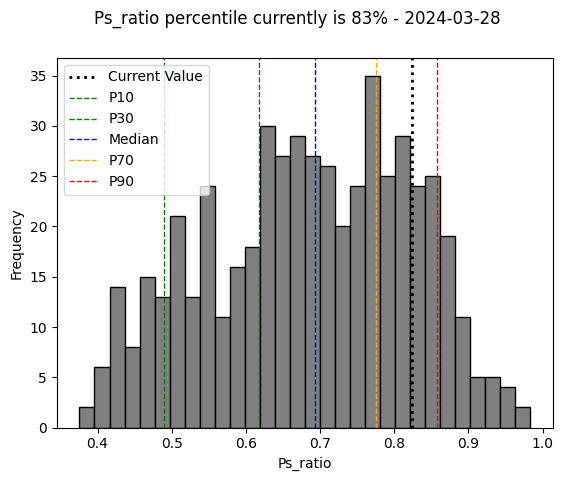

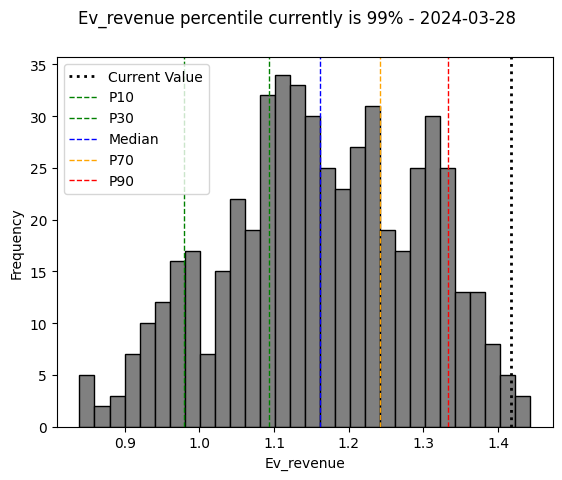

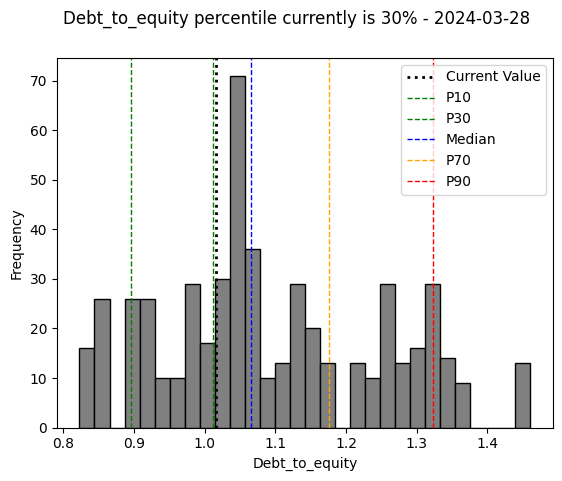

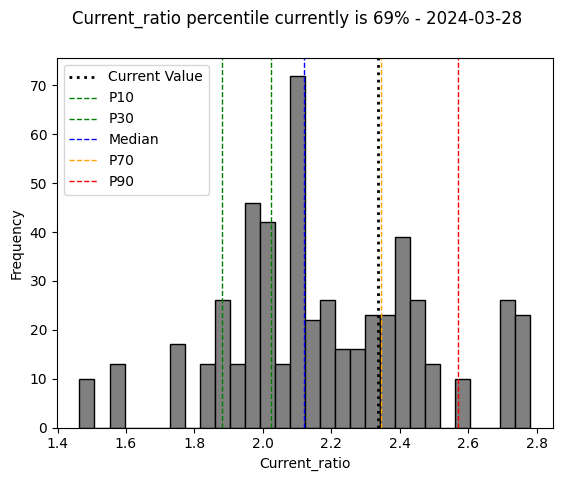

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.996429,-0.378024,0.175464,0.149394,-0.037528,-0.115767,0.090501
roe,0.996429,1.000000,-0.379679,0.219359,0.140466,-0.034587,-0.040482,0.071974
pe_ratio,-0.378024,-0.379679,1.000000,-0.159016,0.015296,0.058373,-0.141048,-0.026851
pb_ratio,0.175464,0.219359,-0.159016,1.000000,0.617528,0.578876,0.452401,0.118894
ps_ratio,0.149394,0.140466,0.015296,0.617528,1.000000,0.920896,-0.302269,0.451680
ev_revenue,-0.037528,-0.034587,0.058373,0.578876,0.920896,1.000000,-0.127809,0.258466
debt_to_equity,-0.115767,-0.040482,-0.141048,0.452401,-0.302269,-0.127809,1.000000,-0.325987
current_ratio,0.090501,0.071974,-0.026851,0.118894,0.451680,0.258466,-0.325987,1.000000


7 timestemos have been found!


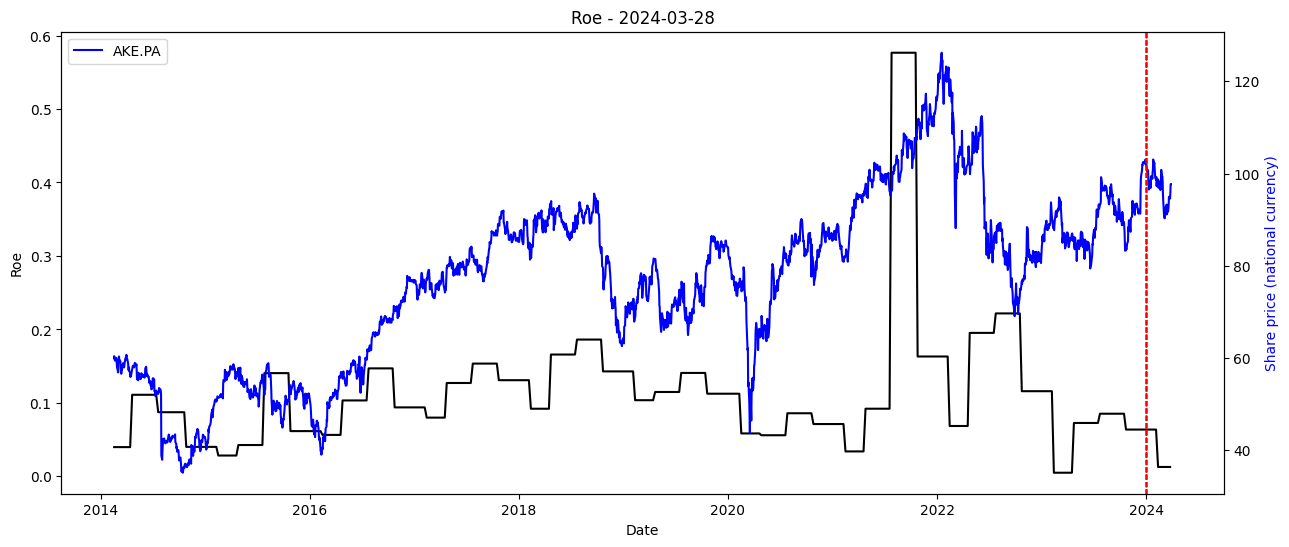

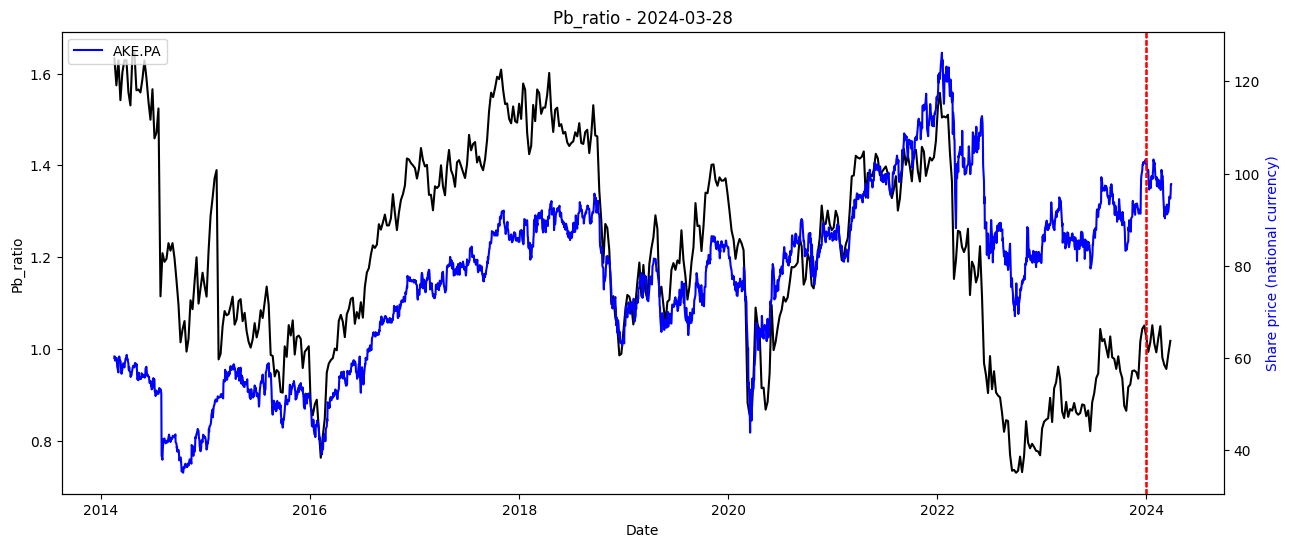

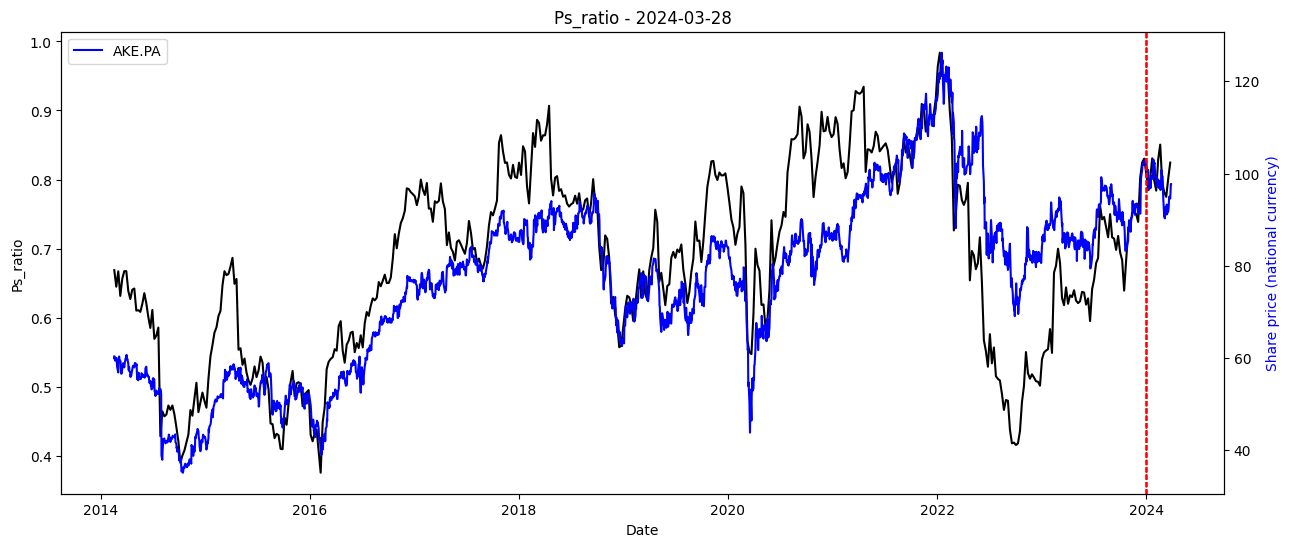

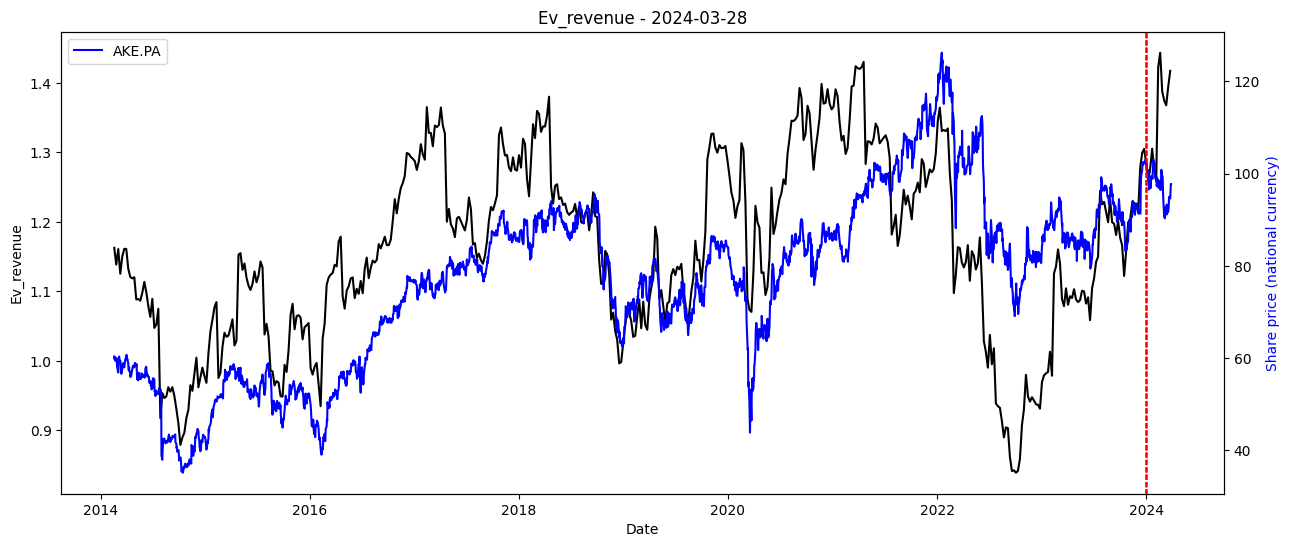

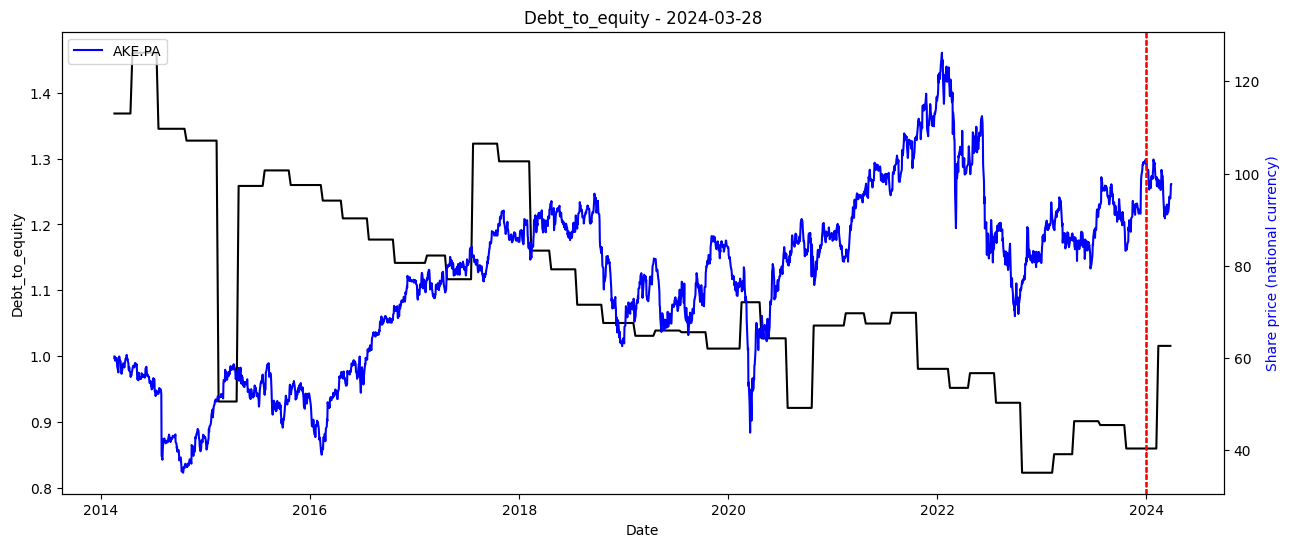

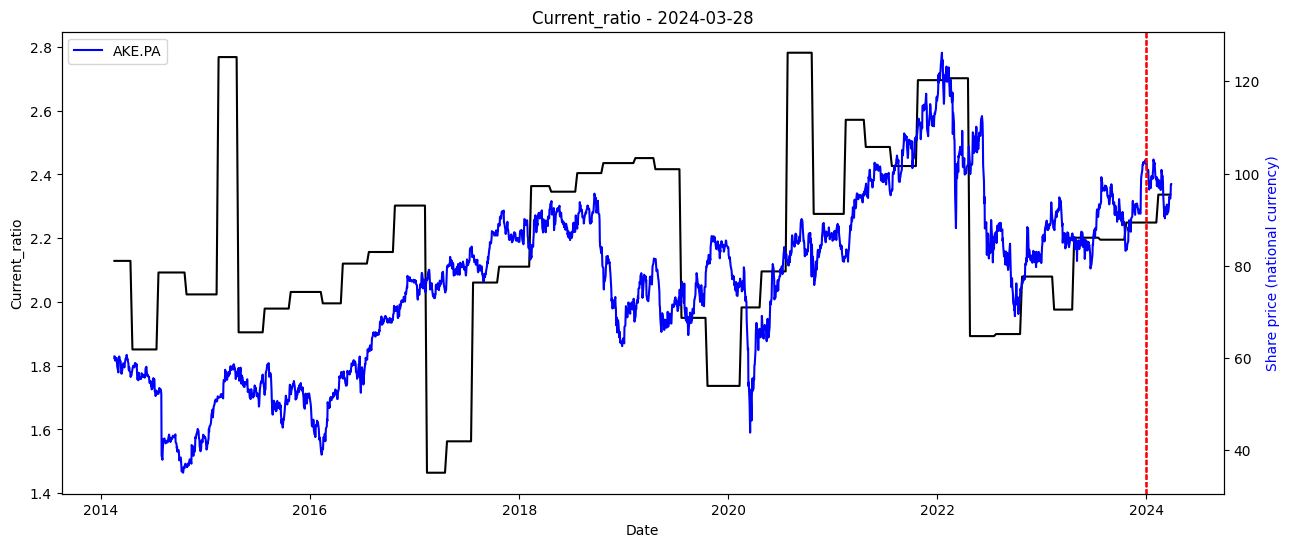

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )